# Comment Classification with BERT

The Wikishop online store is launching a new service. Now, users can edit and supplement product descriptions, similar to wiki communities. That is, customers offer their edits and comment on others' changes. The store needs a tool that will search for toxic comments and send them for moderation.

Train a model to classify comments as either positive or negative. You have a dataset with edit toxicity markup.

Build a model with an F1 quality metric value of at least 0.75.

## Preparation

In [1]:
import torch
import transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb

from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

## Data overview

In [2]:
df = pd.read_csv('toxic_comments.csv')

In [3]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


We have a dataset of 159292 rows. The dataset contains the following features:

* `Unnamed: 0` - old index, let's get rid of it right away
* `text` - tweet text
* `toxic` - tweet toxicity, target feature. Contains values 0 and 1

## Data preprocessing

### Removing the old index

In [6]:
df.columns

Index(['Unnamed: 0', 'text', 'toxic'], dtype='object')

In [7]:
df = df.drop('Unnamed: 0', axis=1)

In [8]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


### Checking values in the target feature

In [9]:
df['toxic'].unique()

array([0, 1], dtype=int64)

In [10]:
target_dist = df['toxic'].value_counts()
target_dist

toxic
0    143106
1     16186
Name: count, dtype: int64

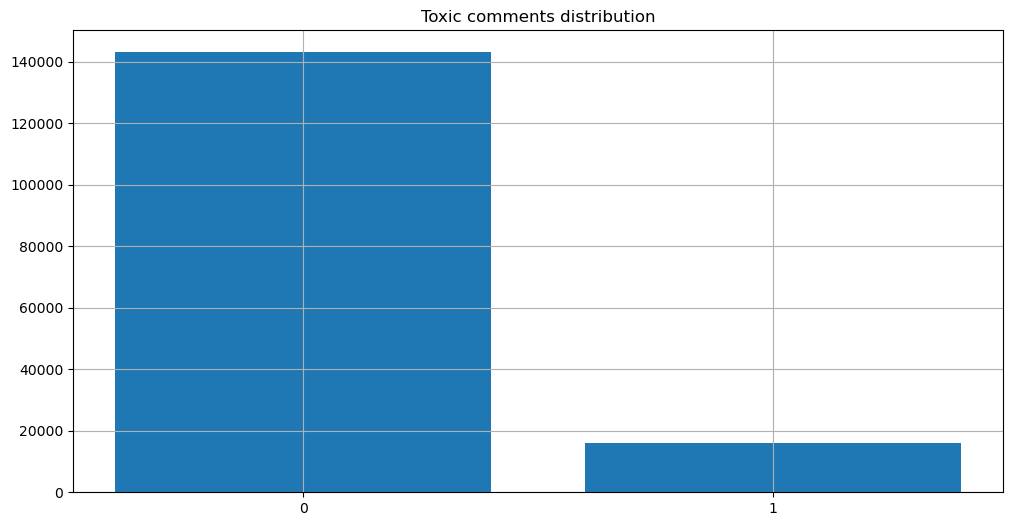

In [11]:
# plot a bar chart to visualize the distribution of toxic comments in the dataset
x = list(target_dist.index)
y = target_dist.array

plt.figure(figsize=(12,6))
plt.title('Toxic comments distribution')
plt.grid(visible=True)
plt.xticks(x)
plt.bar(x, y)
plt.show()

In our dataset, the proportion of toxic comments is only about 10%. The dataset is heavily biased towards non-toxic comments.

### Preparing a sample

We use only part of the dataset, because creating embeddings and training models on the full dataset can take a lot of time.

In [12]:
df_sample = df.sample(2000, random_state=42).reset_index(drop=True)

In [13]:
df_sample

,text,toxic
0,"Sometime back, I just happened to log on to ww...",0
1,"""\n\nThe latest edit is much better, don't mak...",0
2,""" October 2007 (UTC)\n\nI would think you'd be...",0
3,Thanks for the tip on the currency translation...,0
4,I would argue that if content on the Con in co...,0
...,...,...
1995,"Welcome!\n\nHello, and welcome to Wikipedia. ...",0
1996,Note that the user zzzzz has removed lots of a...,0
1997,If you seriously believe there are more episod...,0
1998,Stanley Cup Playoffs\n\nThe East Conference is...,0


In [14]:
# Check the distribution of the target feature
df_sample['toxic'].value_counts()

toxic
0    1786
1     214
Name: count, dtype: int64

## Data preparation

The unitary/toxic-bert model is used to create embeddings

Model link: https://huggingface.co/unitary/toxic-bert

### Tokenization

Tokenize the text. We will limit the text length to 512 tokens, as this is the maximum for the model. Add indents and prepare attention_mask.

In [15]:
tokenizer = transformers.BertTokenizerFast.from_pretrained('unitary/toxic-bert')

tokenized = df_sample['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512, padding='max_length', truncation=True))

In [16]:
prepared = np.array([i for i in tokenized.values])

In [17]:
prepared

array([[ 101, 8811, 2067, ...,    0,    0,    0],
       [ 101, 1000, 1996, ...,    0,    0,    0],
       [ 101, 1000, 2255, ...,    0,    0,    0],
       ...,
       [ 101, 2065, 2017, ...,    0,    0,    0],
       [ 101, 6156, 2452, ...,    0,    0,    0],
       [ 101, 2017, 1005, ...,    0,    0,    0]])

In [18]:
prepared.shape

(2000, 512)

In [19]:
attention_mask = np.where(prepared != 0, 1, 0)

In [20]:
attention_mask

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

### Converting tokens to embeddings

In [21]:
embed_model = transformers.BertModel.from_pretrained('unitary/toxic-bert')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
embed_model.to(device);

In [22]:
def embed(model, tokenized_data, attention_mask, batch_size):
    embeddings = []
    for i in tqdm(range(tokenized_data.shape[0] // batch_size)):
        batch = torch.LongTensor(tokenized_data[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])

        batch = batch.to('cuda')
        attention_mask_batch = attention_mask_batch.to('cuda')
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

    return embeddings

In [23]:
batch_size = 20

embeddings = embed(embed_model, prepared, attention_mask, batch_size)

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\cake\anaconda3\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


In [24]:
features = np.concatenate(embeddings)
features

array([[-0.6170207 , -1.0142671 ,  0.8274097 , ..., -0.8287158 ,
         0.5733    ,  0.03446032],
       [-0.4693603 , -0.9448781 ,  0.7954195 , ..., -0.63105774,
         0.5056714 ,  0.16782281],
       [-0.6633926 , -0.9154767 ,  0.4726571 , ..., -0.6053768 ,
         0.411482  ,  0.08555199],
       ...,
       [-0.5558503 , -0.9715062 ,  0.5546094 , ..., -0.75527006,
         0.5228087 ,  0.05091452],
       [-0.7262837 , -1.1527034 ,  0.7055753 , ..., -0.82303685,
         0.3814967 ,  0.19090636],
       [-0.7451651 , -0.91121304,  0.65300035, ..., -0.61018914,
         0.40986693,  0.17400615]], dtype=float32)

In [25]:
features.shape

(2000, 768)

## Training models

### Preparing samples

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features, df_sample['toxic'], test_size=0.3, random_state=42, stratify=df_sample['toxic'])

### Function for GridSearchCV

In [27]:
# Function to find the best model
def best_model_search_cv(model, params, n_jobs=-1):
    grid = GridSearchCV(model, params, cv=5, n_jobs=n_jobs, scoring='f1', verbose=4)
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_score_, grid.best_params_

### Logistic Regression

In [28]:
# Parameters for the first run of GridSearchCV
params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}

# Best parameters obtained after the first run of GridSearchCV

params = {
    'C': [100]
}


estimator_lr = LogisticRegression(random_state=42, class_weight='balanced')

best_model_lr, best_score_lr, best_params_lr = best_model_search_cv(estimator_lr, params)

display(f'Best params: {best_params_lr}')
display(f'F1-score of the best model: {best_score_lr}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


"Best params: {'C': 100}"

'F1-score of the best model: 0.9134389247247844'

### Random forest

In [29]:
# Parameters for the first run of GridSearchCV
params = { 
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': ['sqrt','log2', 1],
    'max_depth' : range(2, 11, 4),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 6, 2)
}

# Best parameters obtained after the first run of GridSearchCV

params = { 
    'n_estimators': [500],
    'max_features': [1],
    'max_depth' : [10],
    'min_samples_leaf': [1],
    'min_samples_split': [2]
}


estimator_rf = RandomForestClassifier(random_state=42, class_weight='balanced')

best_model_rf, best_score_rf, best_params_rf = best_model_search_cv(estimator_rf, params)

display(f'Best params: {best_params_rf}')
display(f'F1-score of the best model: {best_score_rf}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


"Best params: {'max_depth': 10, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}"

'F1-score of the best model: 0.9443914493519987'

### LightGBM

In [30]:
# Parameters for the first run of GridSearchCV
params = {
    "max_depth": [-1, 6, 10],
    "num_leaves": [20, 31, 40],
    "learning_rate": [0.05, 0.1],
    #"n_estimators": [100, 300],
    #"colsample_bytree": [0.3, 0.5, 0.7, 1]
}

# Best parameters obtained after the first run of GridSearchCV

params = {
    "max_depth": [-1],
    "num_leaves": [20],
    "learning_rate": [0.1],
}


estimator_lgb = lgb.LGBMClassifier(objective='binary', n_jobs=-1, random_state=42)

best_model_lgb, best_score_lgb, best_params_lgb = best_model_search_cv(estimator_lgb, params,  1)

display(f'Best params: {best_params_lgb}')
display(f'F1-score of the best model: {best_score_lgb}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 120, number of negative: 1000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195832
[LightGBM] [Info] Number of data points in the train set: 1120, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.107143 -> initscore=-2.120264
[LightGBM] [Info] Start training from score -2.120264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

"Best params: {'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 20}"

'F1-score of the best model: 0.9242855121675155'

### Conclusion

Three models were trained: logistic regression, random forest and LightGBM. As a result, the following F1-score metrics were obtained:

In [31]:
display(f'F1-score')
display(f'Logistic Regression: {best_score_lr.round(5)}')
display(f'Random Forest: {best_score_rf.round(5)}')
display(f'LightGBM: {best_score_lgb.round(5)}')

'F1-score'

'Logistic Regression: 0.91344'

'Random Forest: 0.94439'

'LightGBM: 0.92429'

The best model was the random forest model.

## Testing the best model

In [32]:
predictions = best_model_rf.predict(X_test)
f'F1-score value on the test sample: {f1_score(y_test, predictions).round(5)}'

'F1-score value on the test sample: 0.96183'

On the test sample, our random forest model showed an F1-score value of 0.96183. This is higher than the required minimum result of 0.75.

## General Conclusion

We have a dataset of 160,000 English-language tweets at our disposal. We needed to train a model that would determine the toxicity of a tweet and have an F1-score metric value of at least 0.75.

We prepared a sample and tokenized the text of the tweets. Then, using the unitary/toxic-BERT model, we created embeddings from the tokens.

We trained 3 different models using GridSearchCV: logistic regression, random forest, and LightGBM. The random forest model showed the best result.

Having tested the random forest model on the test sample, we obtained an F1-score metric value of 0.96183. This is higher than the required minimum result of 0.75. The project goal is achieved.